Нужен matplotlib 2.1

### Примечание
В тексте будет часто встречаться фраза "по ряду причин". И причины эти раскрываться не будут, потому что они либо очень пространны в изложении и не имеют никакого отношения к машинному обучению, либо попадают под положение о коммерческой тайне.
### Цель работы
Автоматическая классификация обращений в техподдержку вместо используемого сейчас ручного труда.
### Описание ситуации
* От пользователей поступает примерно 3000 обращений в техподдержку по различным каналам (телефон, почта, самостоятельная регистрация через ServiceDesk). Все эти обращения вручную классифицируются (зачем человек обратился) и маршрутизируются (кто будет делать).
* Недавно произошла смена программной платформы ServiceDesk с одного продукта на другой. Поэтому большая историческая база заявок у нас есть в одной системе, а новые заявки обрабатывать надо в другой
* При смене платформы произошла полная смена классификатора. В старой было дерево предметных областей. В новой - дерево услуг, у каждой из которых есть категория, а у части - ещё подкатегория. При таком изменении подхода возникло несколько типов ситуаций:
    * По некоторым предметным областям работы в новой системе просто не ведутся.
    * У некоторых предметных областей из старой системы есть однозначное соответствие связки "услуга-категория-подкатегория" в новой.
    * У многих произошло разбиение на 2-3 категории. Например, был "Удалённый доступ через VPN". Он превратился в "Предоставление VPN", "Продление VPN", "Поддержка VPN". Смысл разбиения: предоставление надо согласовывать с ИБ, продление - нет, а поддержкой занимаются совсем другие люди.
    * Новый классификатор основан на услугах для пользователя, он ещё в процессе доработки, поэтому возникают ситуации дублирования. Например, когда пользователю надо установить клиент для VPN-подключения, это вроде бы "Установка прочего ПО". Но "Поддержка VPN" тоже подходит. Это сильно повлияет на оценку точности модели.
* При смене платформы также инженеры получили возможность переназначить заявку, не меняя значение классификатора. В старой системе такого не было. Это сильно повысило удобство работы в системе. Но, как следствие, мы получили много заявок с неправильным выбранным значением услуги. Очевидная идея переклассифицировать существующие заявки по последнему решавшему не работает по ряду причин (не будем на них останавливаться). Так что при обработке данных значительная часть работы заключается в корректной переклассификации заявок в новую систему услуг-категорий-подкатегорий.

### Входные данные и постановка задачи
Входные данные - письмо пользователя с описанием проблемы. На первом этапе внедрения обрабатываются только входящие письма, т.е. у нас есть заголовок письма, тело письма и его автор. 

На выходе надо получить:
* Классификацию (услуга, категория, подкатегория).
* Признак срочности (надо ли эту заявку решать раньше прочих).
* Метрику уверенности в классификации.

Особенность постановки задачи в том, что допускается ответ классификатора "я не знаю". Более того, этот ответ лучше, чем ошибочная классификация. Следствия такой постановки:
* Можно игнорировать редкие классы, если модель на них будет выдавать ответ "я не знаю". Данные сильно несбалансированы (на этом остановимся позже), так что такая возможность сильно упрощает задачу.
* Требуется соблюсти некий баланс между количеством заявок, по которым модель даёт уверенный ответ и количеством ошибок при этом. 

### Выделение признаков
Из письма пользователя необходимо выделить максимум информации и очистить ей от мусора. Можно выделить следующее:

|Блок информации|Признаки   |Примечания   |
|:---|:---|:---|
|Тема и текст письма|bag-of-word, полученный vectoriser`ом|Требуется предобработка. Очистка от служебной информации, приписок про коммерческую тайну, мобильных телефонов пользователей и прочего. Отдельная проблема - когда письмо несколько раз пересылается, прежде чем попадёт на обработку. Кроме того, можно проветси ряд дополнительных преобразований, например: <ul><li>ip-адреса заменить на константу IPADDRESS (чтобы всё многообразие адресов воспринималось классификатором именно как "в заявке есть ip-адрес"</li><li>Аналогочно обрабатывать номера документов ERP-системы, в первых двух цифрах которых закодирован функциональный модуль</li></ul>|
|Отправитель письма|Подразделение пользователя|Некоторыми информационными системами пользуется очень ограниченный круг людей. В том числе очень схожими по функционалу системами. Вплоть до того, что иногда отдел пользователя - это единственный критерий, по которому можно определить информационную систему, потому что ключевые слова используются одни и те же|
|Вложения к письму|Сложный вариант - анализ изображений нейросетями. Простой вариант - средний цвет изображений, превышающих определённый размер|Иногда пользователи не утруждают себя описанием ситуации, если скриншота с ошибкой человеку достаточно дял классификации.|

На первом этапе внедрения ограничимся работой только с темой и текстом письма.

### Первичный анализ данных
1. У нас есть 2 выгрузки заявок из двух разных сервисдесков. По сути своей заявки в обеих системах примерно одинаковые, но классификаторы (а это - целевая переменная) используются разные. Переклассификация будет отдельным пукнтом работы
2. Надо проверить, насколько много ткста у нас есть в описаниях.
3. Каждый элемент классификатора предполагает правила назначения ответственного исполнителя. В процессе обработки заявки она может быть как переклассифицирована, так и переназначена. В новом сервисдеске, в отиличе от старого, переназначение не требует обязательной переклассфикации (переклассификация ведёт к переназначению). Надо проверить, как назначение не соответствует классификации - этот показатель косвенно говорит об ошибке классификации. Возможно, подобные заявки стоит исключать из обучающей и отложенной выборок.

#### Посмотрим на длину текста
Будем рассматривать число не символов, но токенов.
Сразу сравним с тем, что потом получится после предобработки данных.

Данные из нового сервисдеска пришлось отдельно приводить к строковому типу. Есть заявки с абсолютно пустым полем "Полное описание", а значит, для анализа придётся склеивать "Краткое описание" и "Полное описание".

In [66]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 14})
df_ca = pd.read_excel("data/raw_export_ca.xlsx") 
df_snow = pd.read_excel("data/raw_export_snow.xlsx")
train_data = joblib.load('data/train.pkl') 
test_data =  joblib.load('data/test.pkl') 


df_snow.rename(columns={"Номер":"ref_num", 
                        "Краткое описание":"summary", 
                        "Описание":"description", 
                        "Группа назначения":"AssignGroup"
                       
                       }, inplace = True)

df_ca["ref_num"] = df_ca["ref_num"].astype("str")
df_ca["summary"] = df_ca["summary"].astype("str")

df_snow["category"] = df_snow["Бизнес-услуга"].fillna("") + "@" + df_snow["Категория"].fillna("") + "@" + df_snow["Подкатегория"].fillna("")

In [67]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [68]:
df_ca["num_tokens"] = df_ca["description"].apply(lambda x: len(x.split())) 
df_snow["num_tokens"] = df_snow["description"].apply(lambda x: len(str(x).split())) 
train_data["num_tokens"] = train_data["text"].apply(lambda x: len(x.split()))
test_data["num_tokens"] = test_data["text"].apply(lambda x: len(x.split()))

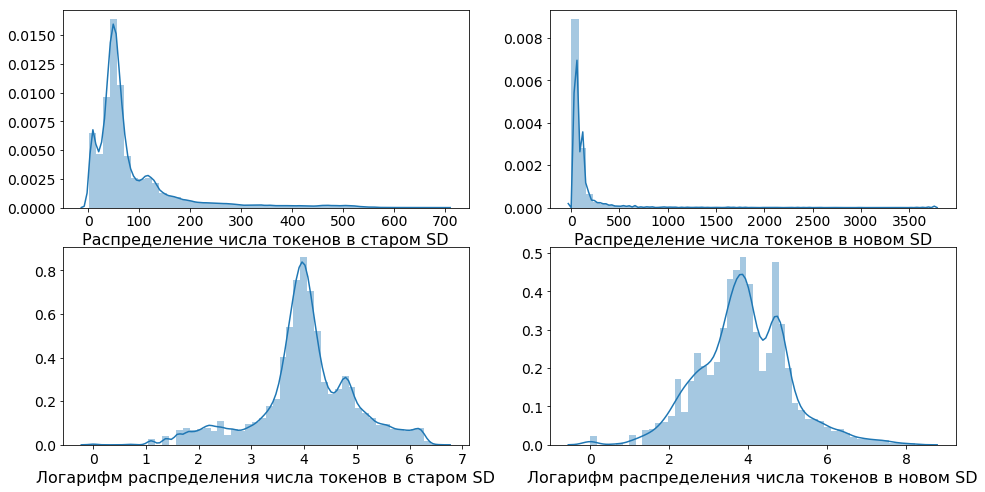

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
sns.distplot( df_ca["num_tokens"], axlabel="Распределение числа токенов в старом SD", ax=axes[0,0])
sns.distplot( df_snow["num_tokens"], axlabel="Распределение числа токенов в новом SD", ax=axes[0,1])
sns.distplot( np.log(df_ca["num_tokens"]), axlabel="Логарифм распределения числа токенов в старом SD", ax=axes[1,0])
sns.distplot( np.log(df_snow["num_tokens"]), axlabel="Логарифм распределения числа токенов в новом SD", ax=axes[1,1]);

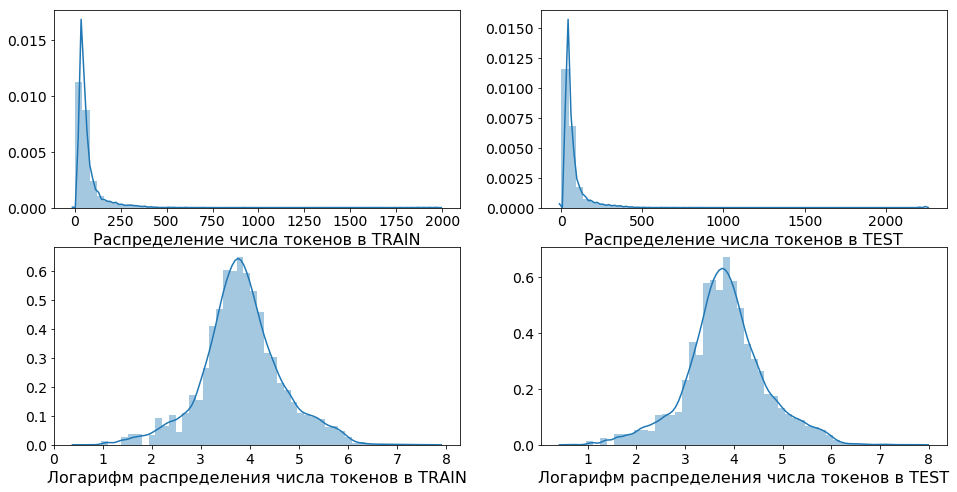

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
sns.distplot( train_data["num_tokens"], axlabel="Распределение числа токенов в TRAIN", ax=axes[0,0])
sns.distplot( test_data["num_tokens"], axlabel="Распределение числа токенов в TEST", ax=axes[0,1])
sns.distplot( np.log(train_data["num_tokens"]), axlabel="Логарифм распределения числа токенов в TRAIN", ax=axes[1,0])
sns.distplot( np.log(test_data["num_tokens"]), axlabel="Логарифм распределения числа токенов в TEST", ax=axes[1,1]);

Такая разница в длине описаний вызвана тем, что в старом SD было ограничение 4000 символов. А в новом ограничений нет.
#### Посмотрим на распределение целевого признака - классификации заявки.
Названия категорий не указаны в качестве подписей из соображений NDA
Количественное распределение говорит нам о значительном дисбалансе классов - четверть заявок относится к трём классам, половина - к 10-13 классам. 
Повторюсь, что у задачи есть две стороны:

**Упрощение**: надо максимизировать количество корректных предсказаний, а не обеспечить 100% полноты по всем классам. Т.е. если корректно выделять 10 классов из 200 - то уже половина работы будет сделана

**Усложнение**: классификаторы в двух сервисдесках разные и надо придумать их сопоставление.

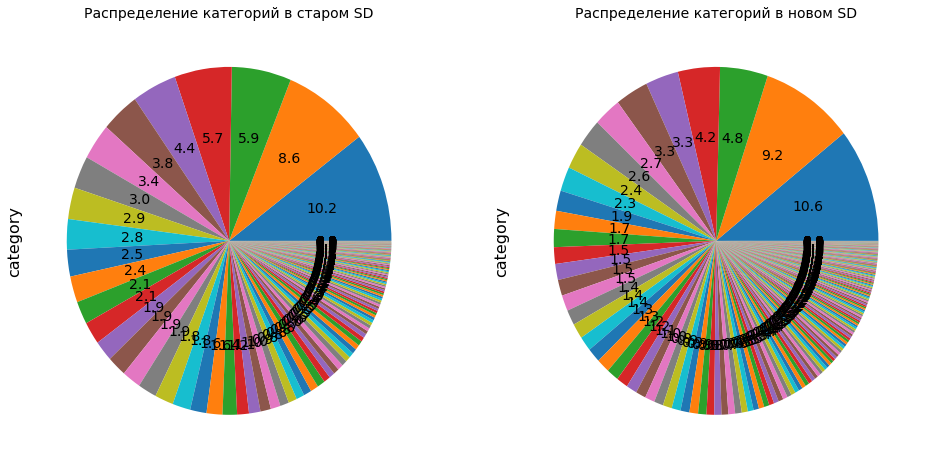

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_ca["category"].value_counts().plot(kind='pie',  
                                      figsize=(16, 8),
                                      labels=None,
                                      autopct='%0.1f',
                                      ax=axes[0],
                                      title="Распределение категорий в старом SD"
                                     )

df_snow["category"].value_counts().plot(kind='pie', 
                                      figsize=(16, 8),
                                      labels=None,
                                      autopct='%0.1f',
                                      ax=axes[1],
                                      title="Распределение категорий в новом SD"
                                     );

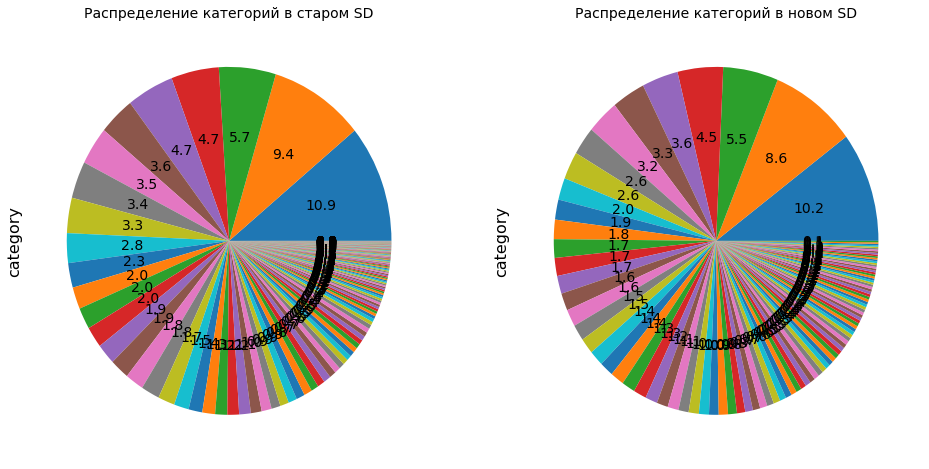

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)
train_data["category"].value_counts().plot(kind='pie', 
                                      figsize=(16, 8),
                                      labels=None,
                                      autopct='%0.1f',
                                      ax=axes[0],
                                      title="Распределение категорий в старом SD"
                                     )

test_data["category"].value_counts().plot(kind='pie', 
                                      figsize=(16, 8),
                                      labels=None,
                                      autopct='%0.1f',
                                      ax=axes[1],
                                      title="Распределение категорий в новом SD"
                                     );

In [7]:
test_data_stats = pd.DataFrame(100*test_data["category"].value_counts()/test_data.shape[0])
test_data_stats.rename(columns={"category":"test_data"}, inplace=True)
test_data_stats.head()

,test_data
SAP@Логистика@,10.222478
"SAP@Полномочия, доступ к системе SAP@",8.592252
"Файлы, папки, Sharepoint@Предоставление нового доступа к файлам, папкам, Sharepoint@",5.485232
Электронная почта@Прочие проблемы с электронной почтой@,4.526275
SAP@Бюджетирование@,3.605677


In [8]:
train_data_stats = pd.DataFrame(100*train_data["category"].value_counts()/train_data.shape[0])
train_data_stats.rename(columns={"category":"train_data"}, inplace=True)
train_data_stats.head()

,train_data
SAP@Логистика@,10.938895
"SAP@Полномочия, доступ к системе SAP@",9.417350
SAP@Учет затрат и проектов@,5.658119
Система электронного документооборота@Поддержка системы электронного документооборота@,4.749249
SAP@Бюджетирование@,4.678244


In [20]:
target_stats = pd.concat([test_data_stats,train_data_stats],axis=1, join='outer')
target_stats["labels"]=target_stats.index.str.replace("@","@\n")
target_stats["labels"]=target_stats["labels"].str.replace("\.","\.\n")
#target_stats.plot(kind="barh",figsize=(10,170),label=target_stats["labels"])
target_stats["test_data"].fillna(0, inplace=True)
target_stats["train_data"].fillna(0, inplace=True)

In [ ]:
plt.figure(figsize=(10,170))
barWidth = 0.25
r1 = np.arange(len(target_stats["labels"]))
r2 = [x + barWidth for x in r1]

plt.barh(r1, target_stats["train_data"], label="train", width=barWidth)
plt.barh(r2, target_stats["test_data"] , label="test" , width=barWidth)

plt.ylabel('group', fontweight='bold')
plt.yticks([r + barWidth for r in range(len(target_stats["labels"]))], target_stats["labels"])


#plt.suptitle('Categorical Plotting')
plt.legend()
plt.show()

In [ ]:
n_groups = len(target_stats["labels"])

means_men = (20, 35, 30, 35, 27)
#std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
#std_women = (3, 5, 2, 3, 3)

#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(16,170))

index = np.arange(n_groups)
bar_width = 0.3

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.barh(index, target_stats["train_data"], bar_width,
                alpha=opacity, color='b',
                
                label='train_data')



rects2 = ax.barh(index + bar_width, target_stats["test_data"], bar_width,
                alpha=opacity, color='r',
                
                label='test_data')
plt.figure(figsize=(10,170))
#rects2.figure(figsize=(10,170))

ax.set_ylabel('Group')
ax.set_xlabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(target_stats["labels"])
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
target_stats["train_data"]

### 6. Выбор модели
В качестве базовой модели выбран SGDClassifier по следующим причинам:
1. Есть хорошая реализация в sklearn.
2. По бенчмарку "20 newsgroups" в том же sklearn этот классификатор показал хорошее сочетание точности и времени на обучение. 
3. Первые же попытки использования показали accuracy 0.6 - 0.7 почти без подготовки данных для обучающей выборки. С учётом специфики задачи я расценил это как очень хороший результат и остановился на этом классификаторе до исчерпания возможности улучшения результатов за счёт подготовки данных.

Было очевидно, что из всего множества токенов и n-грам в мешке слов некоторые имеют гораздо больший вес для принятия решения, чем прочие. Кроме того, в описаниях заявок встречались конструкции, которые не могли эффективно войти в статистику, но при этом были важны. Например, IP адрес сервера, встречается однажды. Но сам факт наличия IP адреса в описании заявки говорит, что она имеет отношения к локальной сети.
Поэтому в дополнение к базовой модели я решил попробовать RandomForest и XGBoost, в качестве обучающих данных для которых использовать самостоятельно выделенные признаки (подробнее в разделе 9)

Основные источники ошибок:
* разные каталоги услуг в двух системах, необходимость маппинга и переклассификации заявок из старой
* некорректная разметка и обучающей, и тестовой выборок. К примеру, есть элементы каталога услуг "Информаицонная система 1" и "Информационная система 1 @ Подсистема". И по правилам классификации часть заяовк должно относиться к одному элементу, а часть - ко второму. В реальности же все заявки по этой системе в старом ServiceDesk относятся к "ИС 1", а в новом - к "ИС 1 @ подсистема 2" независимо от их содержания.
* скрины без описания
* форварды